# **<center>Object Detection for AFM Images</center>**


<center>Authors: W. Capp</center>

This code acts as a central foundation towards the progression of introducing object detection and image classification for AFM images produced via AFM machines in CSV format and for Images produced using the simulation code. The code runs strictly for google colab and relies on google drive, along with the python modules TensorFlow 2.8 and Keras 2.8 (and many others).

The code is seperated into 3 sections.

1.   [Training a new image data set using an existing YOLO model](#Training)
2.   Restarting the necessary functions to use object detection without the tedious previous steps
3.   Object Detection for Current Trained Data Set

The notebook is established to help build future data sets using google colab and an individuals own image datasets. However, it can also be used with the dataset I have produced briefly myself.

For the majority of the notebook we will be setting up the data set and training configurations, then of course training our data set using the pre-established model.

**Note: I have placed python `%%capture` magic commands throughout the code to hide long scary outputs, mostly for my own sanity when facing the crisis brought on by the errors I have witnessed setting this up. They have no affect other than restricting outputs, however this can cause some issues in some code cells. If a cell is not running please delete this line from the cell blocks and re-run to debug. I also suggest removing them all on your first time working with and running the code**

<a name="Training"></a>
## 1.0 Training a New Data Set

The first step to training a new data set is to create your images for the object detection or classification. The process of which depends on what you final goal is. For the work I have done, I was focussed on creating object detection for imaging artefacts in AFM images. This of course requires AFM images and object detection. 

For image recognition, we require a folder of relevant images and annotations in the format of .jpg for images and .xml for annotations. There are many ways to produce XML files, all which share the same characteristic of being a pain to set up. Different types of XML annotation programmes have different capabilities, that is, some allow for simple but faster label creation using just squares and others allow more complex shape creation using points and polygons. In the end, I used the labelImg programme found at https://github.com/tzutalin/labelImg. Being one of the easiest for set up and image labelling. (See appendix for set-up)

With two folders of images and annotations we can now begin to set-up the google drive for our data sets. Bear in mind, you will need to create a decent number of images to see good results - a minimum of around 100.

Now with that done we can move onto the code of the notebook! First step, importing the main libraries of the notebook.







### 1.1 Importing libraries

In [1]:
### Libraries
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf

### 1.2 Setting up our GDrive environments

The next few steps will take place in the google drive you wish to connect to google colab.

Please follow the next steps in order:



1.   In your main drive, create a new folder named `ColabImageDetection`
2.   Now create a folder named `training` within the `ColabImageDetection` folder
3.   And another folder named `dataset` in `ColabImageDetection`
4.   Add the images you created earlier to a folder named `images` and zip the file using WinZip (or free online alternative of your choice)*
5.   Add your XML annotation files to a folder named `annotations` and zip them
6.   Upload both zipped folders into the `ColabImageDetection` main folder
7.   Download and upload the [`generate_tfrecord.py`](https://github.com/techzizou/Train-Object-Detection-Model-TF-2.x) python file to the main `ColabImageDetection` folder. (Click file name to download)

With these steps completed we are ready to mount our google drives and begin to clone and install the TensorFlow object detection APIs.

*We zip these files as usually huge image datasets require a long time to upload to google drive (or in general) so zipping saves lots of time for users.





In [ ]:
### Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Creating a symbolic link (e.g. /mydrive is now equivalent to /content/gdrive/MyDrive) hence shortens code in later cells
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

### 1.3 Cloning TensorFlow Models from GitHub, then installing necessary Object Detection API

In [3]:
%%capture
### Clone tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

### Navigate to /models/research (within colab local drive) folder to compile protos
%cd models/research

# Compile protos ()
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

We will now test the model builder! 

The following cell has a `%%capture` command for my own sanity. However if it is your first time running the code I suggest you remove it and familiarise yourself with the output. As the desired output should end something like this:

---
Ran 24 tests in 40.000s

OK (skipped=1)

---
If it doesn't look like this something is fishy... Try re-running the earlier codes and make sure you have TensorFlow 2.X



In [ ]:
%%capture
### Testing model builder
!python object_detection/builders/model_builder_tf2_test.py

### 1.4 Producing More Files in the GoogleDrive and `ColabImageDetection` folder

We now have all the relevant libraries and APIs we need for image detection. Now we must create the final few files needed. We will do this in 5 steps:

1.   Unzipping our image and annotation files from earlier into new `images` and `annotations` folders into the `data` folder
2.   Dividing image set into test_labels an train_labels 
3.   Creating CSV files and the `label_map.pbtxt` file
4.   Creating the train.record and test.record files
5.   Downloading the pre-existing trained models for training our own data



#### 1.4.1 Unzipping Files

In [ ]:
%%capture
### Unzipping image and annotation folders
# Moving to data folder in drive
%cd /mydrive/ColabImageDetection/data/

# Unzip our datasets into respective images and annotation folders inside the data folder
!unzip /mydrive/ColabImageDetection/images.zip -d .
!unzip /mydrive/ColabImageDetection/annotations.zip -d .

### If you have the %%capture magic command and already have images or annotation
### files you will need to tell the code whether to replace the existing files or
### not. In this case it would be best to remove the magic command. 
### Alternatively, you can save yourself some stress and just click the flashing
### box and simply type the capital letter A, then press enter 

#### 1.4.2 Test and Train labels

Creating testing and training data sets is super important for machine learning. We use the train data set for training our AI (obviously) and the testing dataset for cross reference when applying the model.

This code requires manual input to select randomly seperate the images and annotations into the data set. It will ask you to input the total number of images you have in your zipped file (it is not necessary that this is exactly correct, but is preferable - considering how easy it is). It will then use your custom input to place 20% of images into the `test_labels` foler and the remaining 80% into the `train_labels` folders.

In [ ]:
ImgCount = int(input('Total Number of Images in Data Set: '))
testCount = (ImgCount // 5) + 1
print(f'The number of test images to seperate is: {testCount}\nPlease adjust the next code cell accordingly')

In [ ]:
%%capture
### Splitting up data set
### Creating test_labels and train_labels directories
!mkdir test_labels train_labels

# Randomly moves desired number of files from annotations to test_labels
# Input the number of images to seperate at the number following `head -`
# Leave no space after the hyphen
!ls annotations/* | sort -R | head -22| xargs -I{} mv {} test_labels/

# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls annotations/* | xargs -I{} mv {} train_labels/

**<center>Warning!!!</center>**


There are often issues that arise at this point due to human error. If you have unbridled trust within yourself then feel free to continue. Otherwise I would suggest now checking you `test_labels` and `train_labels` folders to see that they both have labels in them.

If not, then delete their entire contents and re-run the previous 3 cells, this time ensuring the number after `head -` is correct. 

If everything is in working order, progress to the next step.

#### 1.4.3 CSV files and the important label map

The next step creates CSV files for our annotation xml files. And more importantly creates the `label_map` in `.pbtxt` format that is required for labeling input images later on. The following code cell, cleverly reads our annotations and creates the text file with each label type applied in the labelImg programme. This is a wonderful short cell that saves us lots of hassel with creating the text file itself and possible errors with incorrect text names.


Code taken from: 
And previously adjusted from: https://github.com/datitran/raccoon_dataset

I have not a clue what this cell does, please see the links for better understanding.

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')   

#### 1.4.4 Train and Test Records

Generates TensorFlow records for out test and train data

In [ ]:
# train.record
!python /mydrive/ColabImageDetection/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

# test.record
!python /mydrive/ColabImageDetection/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record

#### 1.4.5 Downloading the Pre-trained Model

Here we will download the pre-trained model we wish to train our dataset with. To be honest this step can be a real hassle when trying to do it yourself. You will most likely face what feels like never ending errors that will leave you with less hair than when you started*. Instead I suggest sticking to the model already being used.

The following code downloads the **`ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz`** file and unzips it.


*By this I mean, many pre-existing models are built for different updates of TensorFlow, Keras and the likes. And having to pip uninstall then install dozens of libraries is best avoided.

In [ ]:
### Download pre-trained model and unzip
# Change the model being downloaded by changing the link after `!wget`
# You will then of course have to change the `!tar` unzipper to the correct file name afterwards

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

### 1.5 Dataset Training Config File

We have now pretty much done all the grunt work with setting up the TensorFlow installations and establishing the files needed in the Google Drive. The next step is to update the config file.

The config file is very important to training. It essentially describes the pre-trained model we are using to train our own dataset. Adjusting the config file is therefore necessary to build our own network.

As is common, we must ensure to be meticulous in updating the config file so as to avoid another encounter between our heads and the table. We will access the config file using google colabs local directory:

1.   Click the folder icon on the left hand of the screen
2.   Follow the file path: /models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config
3. Double click the file to open it in colab.

If this is done correctly you should have a text file on the right hand side of your screen. We will now work through this file and change the relevant lines to work with out code!

1.   **Line 13:** Change `num_classes` to number of unique label names you have
2.   **Line 142:** Change `fine_tune_checkpoint` to following path name "/content/gdrive/MyDrive/ColabImageDetection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0"
3.   **Line 143:** Change `fine_tune_checkpoint_type` to "detection"
4.   **Line 144:** Change `batch_size` to any multiple of 8 (depending on GPU - I use 16)
5.   **Line 148:** Change `num_steps` to determine how long your model trains for (this step is not so important as you can forcibly stop the model training if you wish to)
6.   **Lines 182 & 194:** Change `label_map_path` to "/content/gdrive/MyDrive/ColabImageDetection/data/label_map.pbtxt"
7.   **Line 184:** Change `input_path` to "/content/gdrive/MyDrive/ColabImageDetection/data/train.record"
8.   **Line 198:** Change `input_path` to "/content/gdrive/MyDrive/ColabImageDetection/data/test.record"

Once all these changes are made run the following cell, to copy your updated config file to your google drive directory. Be sure to check that it is there and has the changes you made.





In [ ]:
### Copy edited config file to our google directory
!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /mydrive/ColabImageDetection/data

### 1.6 Loading TensorBoard

We will now load a helpful tool, TensorBoard, provided for TensorFlow that will allow us to track the progress of our trained models.

At first it will have nothing to show as we have not trained anything. However, we will recall it later and it will other lots of helpful details into our trained model.

In [ ]:
%load_ext tensorboard         
%tensorboard --logdir '/content/gdrive/MyDrive/ColabImageDetection/training'

### 1.7 Training our Model!!!

And now after the painful set-up process we can finally start the painful training process! First we will need to re-route ourselves to the local `object_detection` directory for TensorFlow.

Unfortunately colab has been updated and runs on a newer version of opencv (how dare they). As consequence, we will need to uninstall this newer version and install the required 4.1.2.30 version.

In [ ]:
### Moving to TensorFlow model object detection directory
%cd /content/models/research/object_detection

/content/models/research/object_detection


In [ ]:
### Downgrading our opencv version
!pip uninstall opencv-python-headless

!pip install opencv-python-headless==4.1.2.30

### If %%capture is on, enter y

Time to train our model! That's right, this whole code leads up to one final line for training our model. The details of which can be found here:

The following cell will spit out a large output, most of which is irrelevant. However, every 1000 steps it will post an update regarding the loss of the system. The time between these updates of course depends on the size of the data set and variables chosen when editing the config. Most importantly, keep in mind that the code is running and the model is training (unless the kernel disconnects or there is a green arrow at the bottom of your screen) and you should not interupt it. 

I suggest whilst waiting for the code to run, you move past it and read on about what I have written with regards to training the data set, the concept of loss, and what to do in case of kernel interruption.

In [ ]:
# Run the command below from the content/models/research/object_detection directory
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""

!python model_main_tf2.py --pipeline_config_path=/mydrive/ColabImageDetection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/mydrive/ColabImageDetection/training --alsologtostderr

### A Brief Introduction to Loss

The concept of training for images simply relates to determining good values for weights and biases for image labeling. In this case we are building a model to minimise the loss by examining many different examples of the images we are exploring. This is called empirical risk mitigation.

For these types of models, the loss is usually the most important factor for understanding how efficient our image detection will be, assuming we are indifferent to the time taken to produce our final images. The loss is essentially a quantitative indication of the error in our model. That is to say a loss of zero is therefore optimal. Although, this is of course an impossible task in actuality. 

Our goal is therefore to produce a model with the lowest loss across the average of all our example images. We follow the general rule that any loss above 0.05 is too great and we should aim for a loss as close to zero as possible.

Such a goal would suggest we should leave code to train 24/7 and infinitely progress towards the impossible goal of zero. However, each dataset has its own restrictions and often begin to plateau after a few thousand steps.

In reality, it is best for us to keep a close eye on our models training and forcibly stop it once we notice the loss begin to oscillate through a small range. This usually takes a few hours mind you. At this point we should then have our final model for object detection and can progress to the final steps!



### 1.8 Exporting an inference graph

In [ ]:
##Export inference graph
!python exporter_main_v2.py --trained_checkpoint_dir=/mydrive/ColabImageDetection/training --pipeline_config_path=/content/gdrive/MyDrive/ColabImageDetection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory /mydrive/ColabImageDetection/data/inference_graph

## 2.0 Restarting Model Training 

If there has been an error whilst training, e.g. the Kernel disconnects, or alternatively you have decided to stop the training yourself. Then there is no need to re-run every individual cell. Instead it will be faster to run only the specific cells contained in this section.

If the model has already been succesfully built, skip this section and move straight onto the final code cell!

In [4]:
### Libraries
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf

In [ ]:
### Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Creating a symbolic link (e.g. /mydrive is now equivalent to /content/gdrive/MyDrive) hence shortens code in later cells
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
### Clone tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

### Navigate to /models/research (within colab local drive) folder to compile protos
%cd models/research

# Compile protos ()
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
### Testing model builder
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/gdrive/MyDrive/ColabImageDetection/training'

In [ ]:
### Moving to TensorFlow model object detection directory
%cd /content/models/research/object_detection

In [ ]:
### Downgrading our opencv version
!pip uninstall opencv-python-headless

!pip install opencv-python-headless==4.1.2.30

### If %%capture is on, enter y

In [ ]:
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""

!python model_main_tf2.py --pipeline_config_path=/mydrive/ColabImageDetection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/mydrive/ColabImageDetection/training --alsologtostderr

## 3.0 Image Object Detection

Congrats you have built your model and survived the process! Now we finally get to the fun part - }not guaranteed. The final code will allow you to import your own images and run them through the object detection model producing a final image with overlayed boxes and labels.

The code in this notebook is specifically designed for AFM images and therefore includes additional image outputs for High contrast images and regular AFM colormaps. The code can and should be adapted in any way that works best for your desired function.

I have also included the functionality to upload via google drive or manually through colabs local drive. I recommend using google drive, as the notebook is already mounted and it allows for easier use of the code. Finally, I have included an option to scan across an entire image folder (do this at your own computers risk), this will allow for large scale projects but will of course take its sweet time.

Feel free to mess around with the source code yourself, as well as the GUI elements. 



### 3.1 Reloading TensorBoard

In [ ]:
%reload_ext tensorboard         
%tensorboard --logdir '/content/gdrive/MyDrive/ColabImageDetection/training'

### 3.2 Imaging Functions

In [ ]:
%cd /content/models/research/object_detection

In [ ]:
### Downgrading our opencv version
!pip uninstall opencv-python-headless

!pip install opencv-python-headless==4.1.2.30

### If %%capture is on, enter y

In [ ]:
# Different font-type for labels text.(This step is optional)
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 50)/" visualization_utils.py
%cd ..

In [ ]:
### Importing Libraries for Object Detection and Image Production
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

### Loading our model
IMAGE_SIZE = (6, 4) # Output display size as you want
PATH_TO_SAVED_MODEL="/mydrive/ColabImageDetection/data/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/mydrive/ColabImageDetection/data/label_map.pbtxt",use_display_name=True)

In [17]:
def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

def ImageObjectDetection(image_path1,ImageName1,image_path2,ImageName2,Output1,Output2,SavetoDrive):
    '''
    Takes Folder and Image Names for Manual upload or Google Drive and runs them through 
    the image detection model they have just created
        Params:
            image_path1 - The file path for the first image
            ImageName1 - The exact name of the first image

            image_path2 - The file path for the first image
            ImageName2 - The exact name of the first image    

            SavetoDrive - Boolean (if true save image outputs to google drive)
            Output1 - The file path for the output folder for the 1st image
            Output2 - The file path for the output folder for the 2nd image
        Returns:
            Prints Images and saves images to google drive output folders
        
    '''

    image_np = load_image_into_numpy_array(image_path1)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image1_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image1_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.75, # Adjust this value to set the minimum probability boxes to be classified as True
        agnostic_mode=False)
    %matplotlib inline
    plt.figure(figsize=IMAGE_SIZE, dpi=200)
    plt.axis("off")
    plt.imshow(image1_np_with_detections)
    if SavetoDrive == True:
        images_dir = Output1
        plt.savefig(f"{images_dir}/{ImageName1}", format ='jpg',transparent=True,pad_inches=0.5)
    plt.show()

    image2_np = load_image_into_numpy_array(image_path2)
    image2_np_with_detections = image2_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image2_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.75, # Adjust this value to set the minimum probability boxes to be classified as True
        agnostic_mode=False)
    %matplotlib inline
    plt.figure(figsize=IMAGE_SIZE, dpi=200)
    plt.axis("off")
    plt.imshow(image2_np_with_detections)
    if SavetoDrive == True:
        images_dir2 = Output2
        plt.savefig(f"{images_dir2}/{ImageName2}", format ='jpg',transparent=True,pad_inches=0.5)
    plt.show()

## 4.0 Final Image Producer GUI

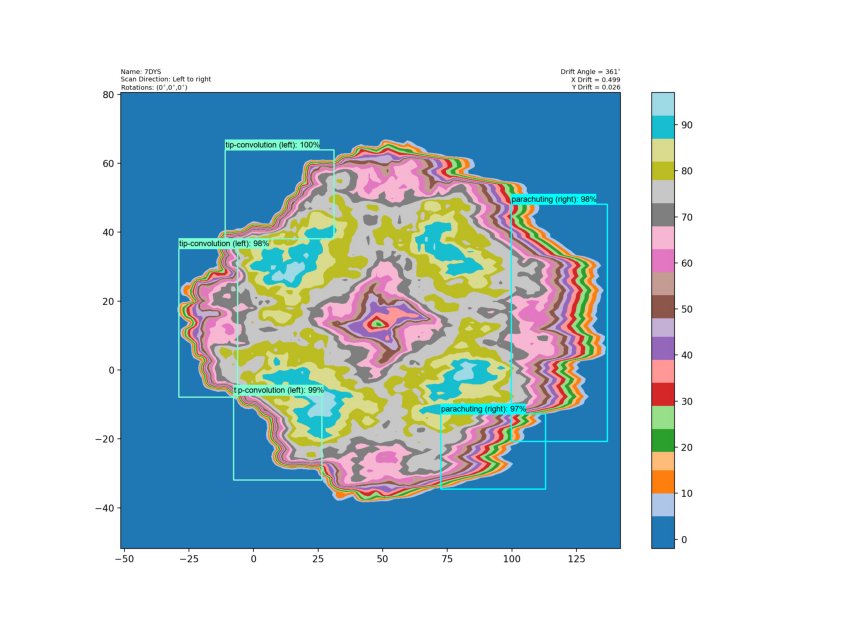

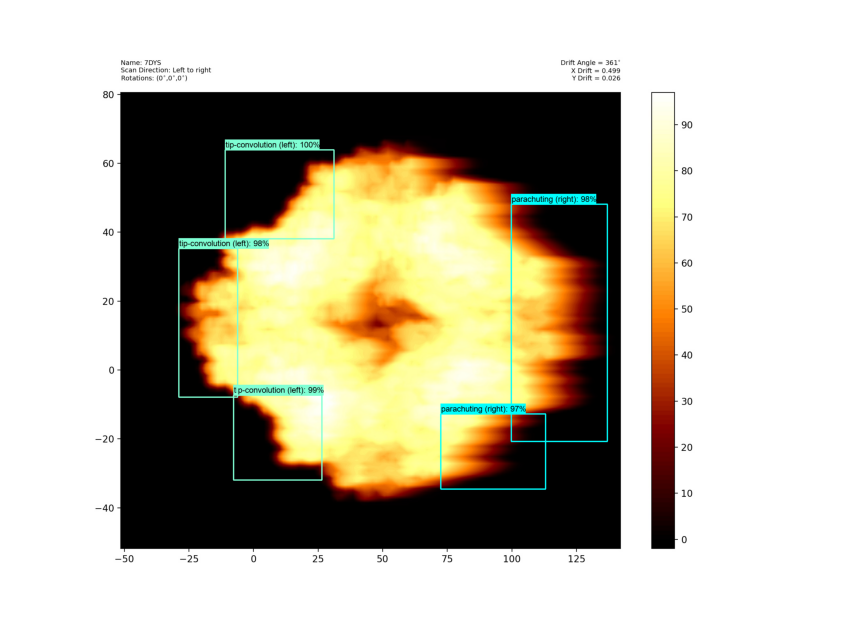

In [18]:
### Importing Libraries for Object Detection and Image Production
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

### Mounting Google Drive


#@title <center>Colab Image Detection</center>

#@markdown Name of Folders Containing Image (/Folder Path)
#@markdown e.g. AFMImages/HighContrast/
FolderName1 = 'AFMImages/HighContrast/' #@param {type:"string"}
FolderName2 = 'AFMImages/Feedback/' #@param {type:"string"}

#@markdown Single Image of Collection of Images
FileType = 'Image' #@param ['Image', 'Folder']

#@markdown Exact Image Names
#@markdown e.g. HighContrast_2zfg_0_0_0_drift
ImageName1 = 'HighContrast_7dys_0_0_0_drift' #@param {type:"string"}
image_path1 = '/mydrive/' + FolderName1 + ImageName1 + '.jpg'
ImageName2 = 'Feedback_7dys_0_0_0_drift' #@param {type:"string"}
image_path2 = '/mydrive/' + FolderName2 + ImageName2 + '.jpg'

#@markdown Output Folder Path for Images
OutputFolder1 = 'AFMImages/ContrastArtefactsAI/' #@param {type:"string"}
Output1 = '/mydrive/' + OutputFolder1
OutputFolder2 = 'AFMImages/FeedbackArtefactsAI/' #@param {type:"string"}
Output2 = '/mydrive/' + OutputFolder2

#@markdown Save Images to Drive?
SavetoDrive = True #@param {type:"boolean"}

if FileType == 'Image':

    ImageObjectDetection(image_path1,ImageName1,image_path2,ImageName2,
                         Output1,Output2,SavetoDrive)
    
if FileType == 'Folder':

    print('Not implemented yet :((')